#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We manually cleaned and split the dataset into sentences

The code in hear is a collections of scripts from [Abhishek Thakur's GitHub](https://github.com/abhishekkrthakur/bert-entity-extraction)

And from the Transformers library and the Trainer API

In [ ]:
!pip install transformers
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert

#Reading Data

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
!unzip ./arabert/ANERCorp_manually_cleaned.zip

Archive:  ./ANERCorp_manually_cleaned.zip
  inflating: ANERCorp_manually_cleaned.tsv  
  inflating: ANERCorp_manually_cleaned_dev.tsv  
  inflating: ANERCorp_manually_cleaned_test.tsv  
  inflating: ANERCorp_manually_cleaned_train.tsv  


In [5]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line=='\n':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split('\t')
      sentence.append(splits[0].replace('\u200f','').replace('·','.'))
      label.append(splits[1][:-1])
      # if you need to cut long sentence, instead of throwing them out in the creation of examples section
      # if len(sentence) > 100 and label[-1] == 'O':
      #   data.append((sentence,label))
      #   sentence = []
      #   label = []  
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [8]:
ANERCorp_path = './arabert/ANERCorp_manually_cleaned'
data_train = read_ANERcorp(ANERCorp_path+'_train.tsv')
data_dev = read_ANERcorp(ANERCorp_path+'_dev.tsv')
data_test = read_ANERcorp(ANERCorp_path+'_test.tsv')

In [11]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_dev for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 13662, 'B-LOC': 446, 'B-PERS': 399, 'I-PERS': 332, 'B-ORG': 214, 'I-ORG': 140, 'B-MISC': 110, 'I-LOC': 64, 'I-MISC': 58})
Counter({'O': 11949, 'B-LOC': 393, 'B-PERS': 336, 'I-PERS': 263, 'B-ORG': 181, 'B-MISC': 132, 'I-ORG': 117, 'I-MISC': 56, 'I-LOC': 50})
Counter({'O': 106366, 'B-LOC': 3589, 'B-PERS': 2866, 'I-PERS': 2236, 'B-ORG': 1630, 'I-ORG': 1134, 'B-MISC': 875, 'I-LOC': 490, 'I-MISC': 432})


In [12]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['O', 'B-PERS', 'B-ORG', 'I-ORG', 'B-LOC', 'B-MISC', 'I-PERS', 'I-LOC', 'I-MISC']


#Model Files

In [10]:
from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess_arabert import preprocess, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from farasa.segmenter import FarasaSegmenter

In [11]:
MAX_SEQ_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0

#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv01'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)


is_arabertv1=False
farasa_segmenter = None
if BASE_MODEL_PATH == 'aubmindlab/bert-base-arabert':
  is_arabertv1=True
  farasa_segmenter = FarasaSegmenter(interactive=True)

In [12]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[1]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


In [13]:
class NERDataset:
  def __init__(self, texts, tags, label_list, is_arabertv1=False, farasa_segmenter=None):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.is_arabertv1 = is_arabertv1
    if self.is_arabertv1:
      assert farasa_segmenter is not None
    self.farasa_segmenter = farasa_segmenter
    
    self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):

      if self.is_arabertv1:
        clean_word = preprocess(
          word,
          do_farasa_tokenization=True,
          farasa=self.farasa_segmenter,
          use_farasapy=True
          )
      else:
        clean_word = preprocess(word, do_farasa_tokenization=False)        
      
      word_tokens = TOKENIZER.tokenize(clean_word)
      if len(word_tokens) > 0:
        tokens.extend(word_tokens)
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
    
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
        tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
        label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
    
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    segment_ids = [0] * len(tokens)

    #Add the [CL]S TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    segment_ids = [0] + segment_ids

    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    input_mask += [0] * padding_length
    segment_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == MAX_SEQ_LEN
    assert len(input_mask) == MAX_SEQ_LEN
    assert len(segment_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("input_mask:", " ".join([str(x) for x in input_mask]))
    #   print("segment_ids:", " ".join([str(x) for x in segment_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'input_mask' : torch.tensor(input_mask, dtype=torch.long),
        'segment_ids' : torch.tensor(segment_ids, dtype=torch.long),
        'label_ids' : torch.tensor(label_ids, dtype=torch.long)       
    }


In [14]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.BertModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
 
    def forward(self, input_ids, input_mask, segment_ids, label_ids):
        o1, _ = self.bert(input_ids, attention_mask=input_mask, token_type_ids=segment_ids)
        bo_tag = self.bert_drop(o1)
        logits = self.out_tag(bo_tag)

        loss_tag = loss_fn(logits, label_ids, input_mask, self.num_tag)
        return logits, loss_tag

In [15]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions,label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [16]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      label_ids = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        logits , loss = model(**data)
        final_loss += loss.item()
        if logits is not None:        
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['label_ids'] is not None:
          label_ids = data['label_ids'] if label_ids is None else torch.cat((label_ids, data['label_ids']), dim=0)

      preds = preds.detach().cpu().numpy()
      labels = label_ids.cpu().numpy()     
    
    return compute_metrics(preds,labels), final_loss

In [17]:
train_dataset = NERDataset(
    texts= [x[0] for x in data_train],
    tags = [x[1] for x in data_train],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=2
)

dev_dataset = NERDataset(
    texts= [x[0] for x in data_dev],
    tags = [x[1] for x in data_dev],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

dev_dataloader = torch.utils.data.DataLoader(
    dataset=dev_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    is_arabertv1=is_arabertv1,
    farasa_segmenter=farasa_segmenter)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

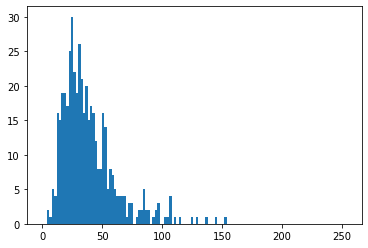

0


In [18]:
# check if the test_dataset is fully covered
tokenized_data = [TOKENIZER.tokenize(preprocess(" ".join(sentence[0]),is_arabertv1,farasa_segmenter,True)) for sentence in data_test]
plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
plt.show()
print(sum([len(x) > 256 for x in tokenized_data]))

In [19]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

num_tag = len(label_list)
model = NERModel(num_tag=num_tag)
model.to(device)
print('MODEL LOADED!')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Wed Sep  2 03:00:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                

In [20]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
print('Number of training steps: ', num_train_steps)
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
)

Number of training steps:  586


#Run Training and Testing

In [21]:
best_f1 = 0
for epoch in range(EPOCHS):
    train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
    eval_metrics, eval_loss = eval_fn(dev_dataloader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
    print(eval_metrics)
    if eval_metrics['f1'] > best_f1:
        torch.save(model.state_dict(), MODEL_PATH)
        best_f1 = eval_metrics['f1']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



           precision    recall  f1-score   support

     PERS     0.8867    0.9288    0.9072       337
      LOC     0.9147    0.9008    0.9077       393
     MISC     0.7778    0.6316    0.6971       133
      ORG     0.7723    0.8619    0.8146       181

micro avg     0.8638    0.8688    0.8663      1044
macro avg     0.8635    0.8688    0.8646      1044

Train Loss = 0.4096704183177928 Valid Loss = 3.9799830531701446
{'accuracy_score': 0.9809849216370794, 'precision': 0.8638095238095238, 'recall': 0.8687739463601533, 'f1': 0.8662846227316141}



           precision    recall  f1-score   support

     PERS     0.9070    0.9258    0.9163       337
      LOC     0.9256    0.9186    0.9221       393
     MISC     0.8205    0.7218    0.7680       133
      ORG     0.8444    0.8398    0.8421       181

micro avg     0.8933    0.8822    0.8877      1044
macro avg     0.8921    0.8822    0.8867      1044

Train Loss = 0.05450192980184141 Valid Loss = 3.950261425692588
{'accuracy_score': 0.984550248830127, 'precision': 0.8933074684772065, 'recall': 0.882183908045977, 'f1': 0.887710843373494}



           precision    recall  f1-score   support

     PERS     0.9043    0.9258    0.9150       337
      LOC     0.9349    0.9135    0.9241       393
     MISC     0.8174    0.7068    0.7581       133
      ORG     0.8603    0.8508    0.8556       181

micro avg     0.8983    0.8803    0.8892      1044
macro avg     0.8971    0.8803    0.8881      1044

Train Loss = 0.03010115595692295 Valid Loss = 4.484058820758946
{'accuracy_score': 0.9838817499814306, 'precision': 0.8983382209188661, 'recall': 0.8802681992337165, 'f1': 0.8892114175133043}



           precision    recall  f1-score   support

     PERS     0.9038    0.9199    0.9118       337
      LOC     0.9404    0.9237    0.9320       393
     MISC     0.8250    0.7444    0.7826       133
      ORG     0.8370    0.8508    0.8438       181

micro avg     0.8964    0.8870    0.8917      1044
macro avg     0.8960    0.8870    0.8911      1044

Train Loss = 0.01940121520823657 Valid Loss = 4.4783943315269426
{'accuracy_score': 0.9847730817796925, 'precision': 0.8964181994191674, 'recall': 0.8869731800766284, 'f1': 0.8916706788637458}



           precision    recall  f1-score   support

     PERS     0.9091    0.9199    0.9145       337
      LOC     0.9503    0.9237    0.9368       393
     MISC     0.7953    0.7594    0.7769       133
      ORG     0.8306    0.8398    0.8352       181

micro avg     0.8964    0.8870    0.8917      1044
macro avg     0.8965    0.8870    0.8916      1044

Train Loss = 0.013510279127562388 Valid Loss = 4.390059662051499
{'accuracy_score': 0.9843274158805615, 'precision': 0.8964181994191674, 'recall': 0.8869731800766284, 'f1': 0.8916706788637458}


In [22]:
model.load_state_dict(torch.load(MODEL_PATH))
test_metrics, test_loss = eval_fn(test_dataloader, model, device)
print(f"Test Loss = {test_loss}")
print(eval_metrics)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



           precision    recall  f1-score   support

     PERS     0.9227    0.9204    0.9215       402
      LOC     0.9057    0.9260    0.9157       446
      ORG     0.8009    0.8084    0.8047       214
     MISC     0.7404    0.6814    0.7097       113

micro avg     0.8777    0.8791    0.8784      1175
macro avg     0.8765    0.8791    0.8777      1175

Test Loss = 4.921557062189095
{'accuracy_score': 0.9843274158805615, 'precision': 0.8964181994191674, 'recall': 0.8869731800766284, 'f1': 0.8916706788637458}
